In [1]:
import trainCNN
# from CnnGAN import Discriminator, Generator, createOnehotSeed, show_plt

cpu


  0%|          | 0/20 [00:00<?, ?it/s, 1/15000, dis_loss: 0.6259, gen_loss: 0.8147]

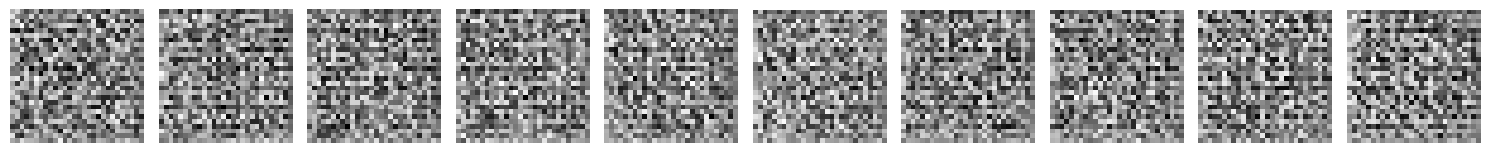

  0%|          | 0/20 [00:05<?, ?it/s, 260/15000, dis_loss: 0.5627, gen_loss: 0.9525]


KeyboardInterrupt: 

In [2]:
train.train()